## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


User-User - рекомендации товаров выбраных(или точнее купленых)похожими между собой пользователями (т.е. со схожими характеристиками: возраст, семейное положение, регион проживания и прочее).

Item-Item - рекомендации для пользователей, используя для рекомендации товары подобные интересующих пользователя (например, на основе покупок таких же товаров другими пользователями или товаров из этой же группы (шампунь-бальзам).

Они похожи способом получения рекомендаций - из матрицы user - item создается матрица User-User (где на пересечении будут метрики отмечающие взаимодействия по сходным товарам) или Item-Item (на пересечении будут взаимодействия по сходным пользователям). А различие в том, что в случае User-User мы находим похожих пользователей, а в Item-Item - товары

В Item-Item мы используем KNN, а в ALS матричное разложение и матрицы ембедингов юзеров и товаров. В ALS учитывается если пользователь не имел взаимодействия с товаром, в Item-Item учитываются только кейсы взаимодействия. В ALS мы используем разложение матрицы на матрицу факторов юзеров и матрицу факторов товаров, а в KNN - используем ее всю. Это позволяет выиграть в скорости

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


1. срок службы купленного ранее товара (например, была куплена электрическая зубная щетка, через три месяца предложить насадки к ней)
2. товары, положенные в корзину, но не купленные (забытые в корзине)
3. товары из той же группы, что были купленны ранее (например, другие книги этого же автора )

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


ALS не учитывает все фичи юзеров и товаров, например такие как пол или сезонность (за исключением случаев, когда по ним было проведено взвешивание), На вход принимает только позитивные взаимодействия, Прогнозирует не вероятность, а некоторые числа, В ALS нельзя добавить внешние фичи

Для разложения User-Item матрицы на матрицы эмбедингов юзеров и товаров необходимо, чтобы каждый пользователь сделал хотя бы одну покупку или чтобы каждый товар купили хотя бы один раз

## Практическая часть


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys


In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [10]:
def precision(recommended_list, 
               bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)
    
def precision_at_k(recommended_list, 
                    bought_list, 
                    k=5):
    return precision(recommended_list[:k], bought_list)

def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],
                                    #filter_items=None, 
                                    recalculate_user=True)]
    return res

def ALS_tester(user_item_matrix, name_of_column):
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

    result[name_of_column] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

def test_the_idea (name_of_column, name_of_func, fill_value=0):
    global user_item_matrix
    global sparse_user_item
    global id_to_itemid
    global id_to_userid
    global itemid_to_id
    global userid_to_id
    
    user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc=name_of_func, 
                                  fill_value=fill_value
                                 )
    

    fill_value
    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values
    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))
    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))
    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
        
    ALS_tester(user_item_matrix, name_of_column)
    

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [11]:
test_the_idea('mean','mean')

In [12]:
test_the_idea('nunique','nunique')

In [15]:
test_the_idea('max','max')

In [16]:
test_the_idea('count', 'count' )

In [17]:
df = pd.DataFrame(columns=['aggfunc', 'presision_at_k'])
i = 0
for column in result.columns[2:]:
    presision = round(result.apply(lambda row: precision_at_k(row[column], row['actual']), axis=1).mean(), 5)
    df.loc[i] = [column, presision]
    i += 1

df.sort_values(by='presision_at_k', ascending=False)

,aggfunc,presision_at_k
1,nunique,0.20323
0,mean,0.18991
2,max,0.18266
3,count,0.18012


Cамый высокий результат даёт "nunique", потому что показывает самые популярные товары

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [20]:
user_item_matrix = pd.pivot_table(data_train, 
                              index='user_id', columns='item_id', 
                              values='quantity', # Можно пробоват ьдругие варианты
                              aggfunc='nunique', 
                              fill_value=0
                             )
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values
matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))
id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))
itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [21]:
valid = data_train.groupby('user_id')['item_id'].unique().reset_index()
valid.columns=['user_id', 'actual']
valid.head(2)

,user_id,actual
0,1,"[999999, 840361, 845307, 852014, 856942, 91267..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556..."


In [22]:
rers_k_test=dict()
rers_k_valid = dict()
n=1

for factors in np.linspace(20,250,5):
    for regularization in np.geomspace(0.0001,0.1,5):

        
        model = AlternatingLeastSquares(factors=int(factors), 
                                        regularization=regularization,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=8)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),show_progress=False)
        
        # train
        result[f'fs={factors}_rg={regularization}'] = \
                        result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k = result.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        # test
        valid[f'fs={factors}_rg={regularization}'] = \
                        valid['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k_valid = valid.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        
        rers_k_test[n] = [factors, regularization, k, k_valid]
        n+=1

KeyboardInterrupt: 

зависает надолго пр выполнении()

In [23]:
summary = pd.DataFrame.from_dict(rers_k_test,orient='index',columns=['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"])
summary[['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"]].sort_values(by='valid_precision_at_k', ascending=False).head(10)

,factors,regularization,train_precision_at_k,valid_precision_at_k
16,192.5,0.000100,0.170911,0.955582
17,192.5,0.000562,0.173555,0.955422
13,135.0,0.003162,0.190304,0.930132
15,135.0,0.100000,0.194809,0.929492
12,135.0,0.000562,0.189128,0.929412
11,135.0,0.000100,0.190304,0.929092
14,135.0,0.017783,0.192165,0.928531
6,77.5,0.000100,0.207640,0.875550
8,77.5,0.003162,0.213124,0.875070
9,77.5,0.017783,0.214202,0.874430


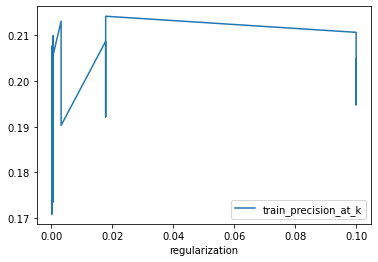

In [24]:
summary.sort_values(by='regularization').plot(x ='regularization', y='train_precision_at_k', kind = 'line')
plt.show()

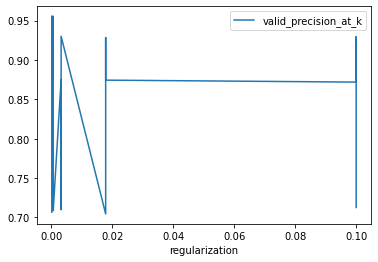

In [25]:
summary.sort_values(by='regularization').plot(x ='regularization', y='valid_precision_at_k', kind = 'line')
plt.show()

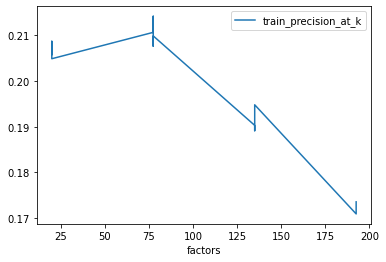

In [26]:
summary.sort_values(by='factors').plot(x ='factors', y='train_precision_at_k', kind = 'line')
plt.show()

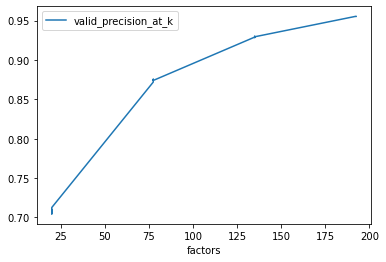

In [27]:
summary.sort_values(by='factors').plot(x ='factors', y='valid_precision_at_k', kind = 'line')
plt.show()

Регуляризация непредсказуемо влияет на качество, в то время как у факторов можно видеть оптимальные участки в районе 80